In [38]:
library(tidyverse)
library(scales)

# Parsing function, which returns a list of two dataframes per experiment: data and metadata
parse_CD_file = function(filepath) {
  
  connection = file(filepath, "r")
  metadata <- data.frame(param=character(), value=character(), stringsAsFactors=F) 
  last_param = ''
  while (T) {
    line <- strsplit(readLines(connection, n = 1), split = '\t')
    last_param <- line[[1]][1]
    if ( length(line) == 0 | last_param == 'XYDATA') {
      break
    }
    metadata <- rbind(metadata, data.frame('param'=line[[1]][1],
                                           'value'=line[[1]][2],
                                           stringsAsFactors=F))
  }
  
  X <- as.character(subset(metadata, param == 'XUNITS')$value)
  Y <- as.character(subset(metadata, param == 'YUNITS')$value)
  Y2 <- as.character(subset(metadata, param == 'Y2UNITS')$value)
  
  data <- data.frame(X=character(), Y=character(), Y2=character(), stringsAsFactors=F) 

  while (T) {
    line <- strsplit(readLines(connection, n = 1), split = '\t')
    if ( length(line) == 0 ) {
      break
    }
    data <- rbind(data, data.frame('X'=as.numeric(line[[1]][1]),
                                   'Y'=as.numeric(line[[1]][2]),
                                   'Y2'=as.numeric(line[[1]][3])))
  }
  colnames(data) <- c(X, Y, Y2)
  close(connection)
  
  # Scale CD data from ellipticity (millidegrees) to molar ellipticity (deg*cm*dmol-1)
  # pathlength = 0.2 cm, concentration = 2e-6 M
  data <- mutate(data, 'Molar ellipticity' = 100 * (`CD[mdeg]`/1000) / (0.2 *2e-6))
  
  return(data)
}


plot_scan <- function(expt) {
    ggplot(expt, aes_string(x = 'NANOMETERS', y = '`Molar ellipticity`')) +
    geom_line(size = 0.2) +
    scale_y_continuous(breaks= pretty_breaks()) +
    geom_hline(yintercept = 0, color = 'red', linetype = 'dashed', size = 0.2) + 
    ggtitle(x$name) +
    xlab('Wavelength (nm)') +
    ylab('Molar Ellipticity (deg * cm / dmol)') +
    theme_classic() +
    theme(
      text = element_text(family = "Helvetica", size = 6),
      axis.title = element_text(size = 6),
      axis.text = element_text(size = 6),
      axis.ticks = element_line(size = 0.05),
      axis.ticks.length = unit(0.05, 'cm'),
      axis.line = element_line(size = 0.1),
      plot.title = element_text(hjust = 0.5, size = 6)
    )
}

$Scan

$Scan_afterMelt


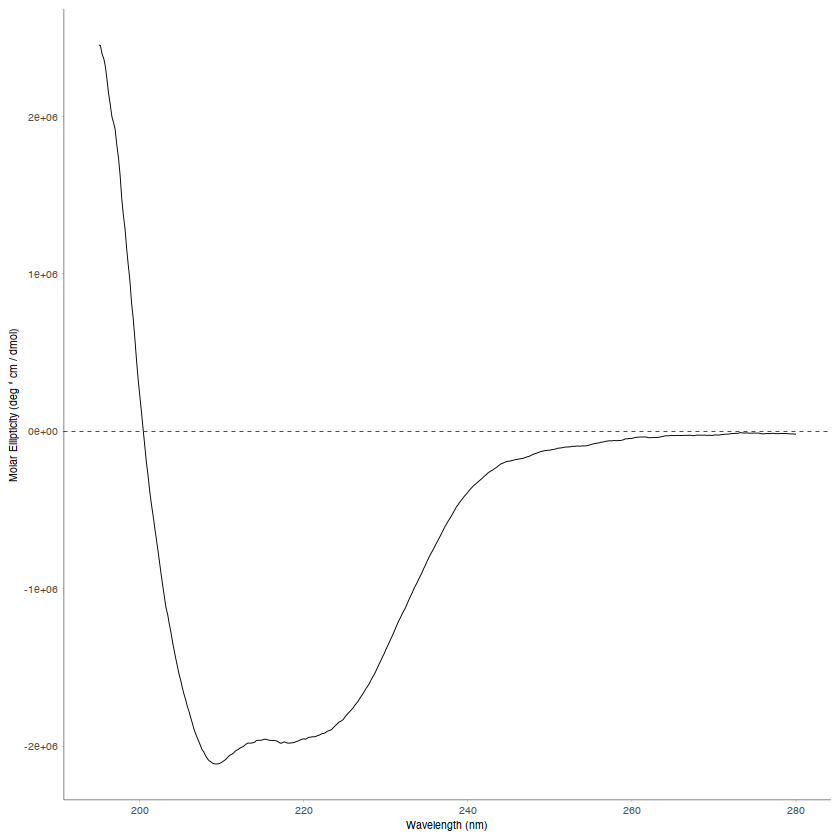

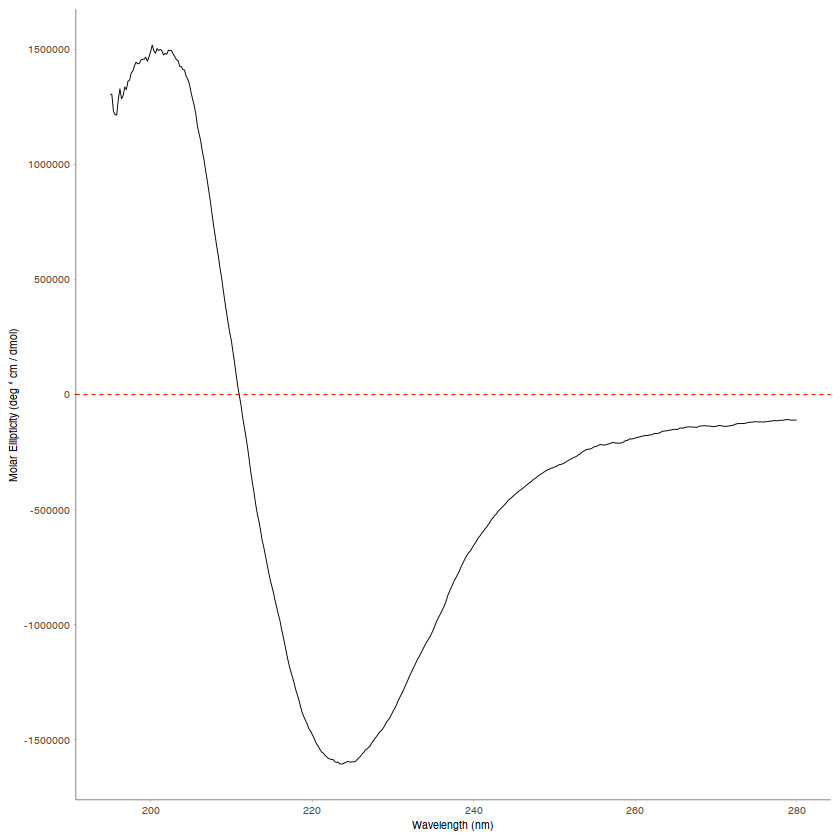

In [40]:
scans_filenames = dir(path = '../analysis', pattern = '2018*', full.names = T)

scans <- lapply(scans_filenames, parse_CD_file)
names(scans) <- lapply(scans_filenames, function(x) substr(x, 40, nchar(x) - 4))

       
lapply(scans, plot_scan)